# If you save a figure please save it as both an svg & jpg

In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from copy import deepcopy

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

In [2]:
relu = lambda x: jnp.maximum(0, x)

### Init #######################################################################

def init_params(hps) -> list:
  '''Returns arrays of initial activities and weights.
  Also returns a key for random generation.
  Inputs:
  Layer sizes and random seed.
  '''

  def init_weights(sizes: list, key) -> list:
    keys = random.split(key, num=len(sizes))
    return [jnp.array(random_layer_params(m, n, k)) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

  def random_layer_params(m: int, n: int, key):
    '''Returns a jax array of random numbers in (n, m) shape.
    This version is He initialization.
    '''
    scale = jnp.sqrt(2/m)
    return scale * random.normal(key, (n, m))

  activities = [jnp.zeros(s) for s in hps['sizes']]
  key = random.PRNGKey(hps['seed'])
  key, subkey = random.split(key)
  weights = init_weights(hps['sizes'], subkey)

  return activities, weights, key

### Usage #######################################################################

@jit
def ff(activities, weights):
  '''A one-step feedforward pass. Returns activities.
  Requires (l-1) calls to do full feedforward pass.
  '''
  new_acts = deepcopy(activities)

  for l in range(len(activities)-1):
    new_acts[l+1] = jnp.matmul(weights[l], relu(activities[l]))

  return new_acts

### Energy function and training ##########################################################################
def energy(activities, weights, activity_history, hps):
  '''Calculates overall prediction loss.
  If beta==1 then noise is only based on the most recent activity.
  '''

  beta = hps['noise_beta']
  C = hps['denom_constant']

  # Update activity_history values
  # (1-beta) * previous_activity_history + beta * new_activity
  for l in range(len(activity_history)):
    activity_history[l] = (1-beta) * activity_history[l] + beta * activities[l]

  energy_sum = 0
  for l in range(len(activities)-1):
    energy_sum += jnp.sum((1/2) * ((activities[l+1] - jnp.matmul(weights[l], relu(activities[l]))) / (jnp.abs(activity_history[l+1]) + C)) ** 2)

  return energy_sum

@jit
def update_acts_energy(activities, weights, activity_history, hps):
  act_grads = grad(energy, argnums=0)(activities, weights, activity_history, hps)
  return [act - hps['gamma'] * d_act for act, d_act in zip(activities, act_grads)]

@jit
def update_weights_energy(activities, weights, activity_history,  hps):
  w_grads = grad(energy, argnums=1)(activities, weights, activity_history, hps)
  return [w - hps['alpha'] * d_w for w, d_w in zip(weights, w_grads)]


### Noise and clip functions ##########################################################################

@jit
def act_noise(activities, activity_history, key, hps):
  ''' Adds noise to each neuron based on its past activity.
  '''

  noise_scale = hps['noise_scale']

  new_activities = [[] for _ in activities]
  for l in range(len(activities)):

    key, subkey = random.split(key)
    noise = random.normal(subkey, activities[l].shape) * noise_scale
    new_activities[l] = activities[l] + noise

  return new_activities, activity_history, key

@jit
def weight_noise(weights, key, hps):
  '''Adds some noise to the weights.
  '''
  new_weights = [[] for _ in weights]
  for l in range(len(weights)):
    key, subkey = random.split(key)
    noise = random.normal(subkey, weights[l].shape) * hps['weight_noise_scale']
    new_weights[l] = weights[l] + noise

  return new_weights, key

@jit
def weight_clip(weights, cap=2.):
  '''Makes sure weights don't go above some magnitude.
  '''
  new_weights = [[] for _ in weights]
  for l in range(len(weights)):
    new_weights[l] = jnp.clip(weights[l], -cap, cap)

  return new_weights


### Log ##########################################################################

class PCNLog():
  ''' Records all current variables in the network.
  .acts[i][t][n] is a list of activities for the ith layer, timestep t, neuron n.
  '''
  def __init__(self, hps):

    self.acts = [[] for _ in range(len(hps['sizes']))]
    self.weights = [[] for _ in range(len(hps['sizes'])-1)]

  def record(self, activities, weights):
    [self.acts[i].append(acts) for i,acts in enumerate(activities)]
    [self.weights[i].append(weights) for i,weights in enumerate(weights)]

  def close(self):
    self.weights = [np.array(w) for w in self.weights]

# Adam: landscape code

In [3]:
def landscape_continuous(image, loc, adapt=False):
  '''Takes an image and returns values of new levers.
  Returns those levers as reward values for input to bandit.
  Also implements wraparound for the image as a "double cylinder".
  '''

  # If no adaptation, then subtract next value from current value.

  imshp = image.shape
  if adapt:
    nowloc = 0.
  else:
    nowloc = image[loc[0], loc[1]]

  # If top edge
  if loc[0]==0:
    up = image[imshp[0]-1, loc[1]] - nowloc
    down = image[loc[0]+1, loc[1]] - nowloc
  # If bottom edge
  elif loc[0]==imshp[0]-1:
    up = image[loc[0]-1, loc[1]] - nowloc
    down = image[0, loc[1]] - nowloc
  else:
    up = image[loc[0]-1, loc[1]] - nowloc
    down = image[loc[0]+1, loc[1]] - nowloc

  # If left edge
  if loc[1]==0:
    left = image[loc[0], imshp[1]-1] - nowloc
    right = image[loc[0], loc[1]+1] - nowloc
  # If right edge
  elif loc[1]==imshp[1]-1:
    left = image[loc[0], loc[1]-1] - nowloc
    right = image[loc[0], 0] - nowloc
  else:
    left = image[loc[0], loc[1]-1] - nowloc
    right = image[loc[0], loc[1]+1] - nowloc

  udlr = jnp.array([up, down, left, right])+1e-6
  return udlr

def move_continuous(loc, motors, udlr, imshape):
  '''Takes loc, motors, udlr, and imshape. Returns the reward of the new spot and the new location coordinates.
  Also implements wraparound for the image as a "double cylinder".
  '''

  lever_ind = jnp.argmax(motors)
  # Up
  if lever_ind==0:
    if loc[0]==0:
      new_loc = [imshape[0]-1, loc[1]]
    else:
      new_loc = [loc[0]-1, loc[1]]

  # Down
  elif lever_ind==1:
    if loc[0]==imshape[0]-1:
      new_loc = [0, loc[1]]
    else:
      new_loc = [loc[0]+1, loc[1]]

  # Left
  elif lever_ind==2:
    if loc[1]==0:
      new_loc = [loc[0], imshape[1]-1]
    else:
      new_loc = [loc[0], loc[1]-1]

  # Right
  elif lever_ind==3:
    if loc[1]==imshape[1]-1:
      new_loc = [loc[0], 0]
    else:
      new_loc = [loc[0], loc[1]+1]

  else:
    raise ValueError('Invalid lever input.')

  return udlr[lever_ind], new_loc, lever_ind

In [5]:
def landscape(image, loc):
  '''Takes an image and returns difference between current location and new levers UDLR.
  Returns those levers as reward values for input to bandit.
  '''
  imshp = image.shape

  # If top edge
  if loc[0]==0:
    up = 0.
    down = image[loc[0]+1, loc[1]] - image[loc[0], loc[1]]
  # If bottom edge
  elif loc[0]==imshp[0]-1:
    up = image[loc[0]-1, loc[1]] - image[loc[0], loc[1]]
    down = 0.
  else:
    up = image[loc[0]-1, loc[1]] - image[loc[0], loc[1]]
    down = image[loc[0]+1, loc[1]] - image[loc[0], loc[1]]

  # If left edge
  if loc[1]==0:
    left = 0.
    right = image[loc[0], loc[1]+1] - image[loc[0], loc[1]]
  # If right edge
  elif loc[1]==imshp[1]-1:
    left = image[loc[0], loc[1]-1] - image[loc[0], loc[1]]
    right = 0.
  else:
    left = image[loc[0], loc[1]-1] - image[loc[0], loc[1]]
    right = image[loc[0], loc[1]+1] - image[loc[0], loc[1]]

  udlr = jnp.array([up, down, left, right])+1e-6
  return udlr

def move(loc, motors, udlr, imshape):
  '''Takes loc, motors, udlr, and imshape. Returns the reward of the new spot and the new location coordinates.
  '''

  lever_ind = jnp.argmax(motors)
  # Up
  if lever_ind==0:
    if loc[0]==0:
      new_loc = [loc[0], loc[1]]
    else:
      new_loc = [loc[0]-1, loc[1]]

  # Down
  elif lever_ind==1:
    if loc[0]==imshape[0]-1:
      new_loc = [loc[0], loc[1]]
    else:
      new_loc = [loc[0]+1, loc[1]]

  # Left
  elif lever_ind==2:
    if loc[1]==0:
      new_loc = [loc[0], loc[1]]
    else:
      new_loc = [loc[0], loc[1]-1]

  # Right
  elif lever_ind==3:
    if loc[1]==imshape[1]-1:
      new_loc = [loc[0], loc[1]]
    else:
      new_loc = [loc[0], loc[1]+1]

  else:
    raise ValueError('Invalid lever input.')

  return udlr[lever_ind], new_loc, lever_ind

In [6]:
def landscape_rot(image, loc, orientation):
  '''Takes an image and returns difference between current location and new levers, ROTATION SCHEME.
  Returns those levers as reward values for input to bandit.
  Levers are: rotate CCW pi/2, go forward, rotate CW pi/2 deg.
  Orientation goes: 0:0, 1:pi/2, 2:pi, 3:3pi/2
  '''
  imshp = image.shape
  original = image[loc[0], loc[1]]

  if orientation==0:
    if loc[1]==imshp[1]-1:
      forward_reward = 0.
    else:
      forward_reward = image[loc[0], loc[1]+1] - original

  elif orientation==1:
    if loc[0]==0:
      forward_reward = 0.
    else:
      forward_reward = image[loc[0]-1, loc[1]] - original

  elif orientation==2:
    if loc[1]==0:
      forward_reward = 0.
    else:
      forward_reward = image[loc[0], loc[1]-1] - original

  elif orientation==3:
    if loc[0]==imshp[0]-1:
      forward_reward = 0.
    else:
      forward_reward = image[loc[0]+1, loc[1]] - original

  else:
    raise ValueError('Invalid orientation')

  lever_rewards = jnp.array([0., forward_reward, 0.]) + 1e-6

  return lever_rewards

def move_rot(loc, motors, lever_rewards, orientation, imshp):
  '''Takes loc, motors, lever rewards, and imshape. Returns the reward of the new spot, the new location coordinates, and the new orientation.
  '''

  lever_ind = jnp.argmax(motors)
  new_loc = deepcopy(loc)

  # No forward movement
  if lever_ind==0:
    # Turn CCW
    orientation = (orientation - 1) % 4
  elif lever_ind==2:
    # Turn CW
    orientation = (orientation + 1) % 4

  # Forward movement
  else:
    if orientation==0:
      if loc[1]!=imshp[1]-1:
        new_loc[1] += 1

    elif orientation==1:
      if loc[0]!=0:
        new_loc[0] -= 1

    elif orientation==2:
      if loc[1]!=0:
        new_loc[1] -= 1

    elif orientation==3:
      if loc[0]!=imshp[0]-1:
        new_loc[0] += 1

  return lever_rewards[lever_ind], new_loc, orientation, lever_ind

In [7]:
# Define plate

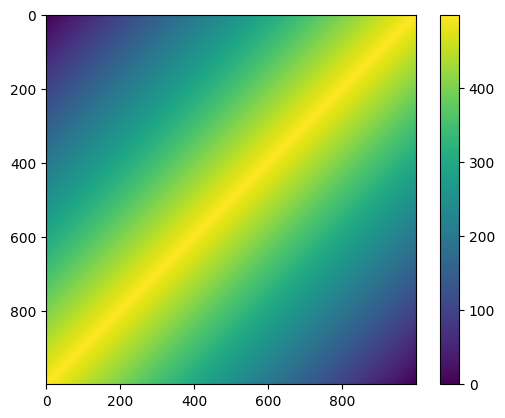

In [8]:
plate = np.zeros((1000,1000))
for i in range(1000):
  for j in range(1000-i):
    plate[i,j] = 0.5*(i+j)
    plate[999-i,999-j] = 0.5*(i+j)
plt.imshow(plate)
plt.colorbar();

In [ ]:
timesteps = 100_000
sizes = [1, 30, 4]
start_seed = 942
rewards = jnp.zeros(4) + 1e-6
plate = plate


initial_input = jnp.array([0.5])


hps = {

    'sizes' : sizes,

    'gamma' : 0.01, # Activity update rate
    'alpha' : 0.01, # Weight update rate

    'noise_beta'  : 0.01,  # Activity history update rate for noise scale
    'denom_constant' : 0.25, # Constant to add to denominator in energy term
    'noise_scale' : 0.01, # Activity noise scale

    'weight_noise_scale' : 0.01, # Weight noise scale

    'seed' : start_seed,

}

activities, weights, key = init_params(hps)
activity_history = deepcopy(activities)

log = PCNLog(hps)
lever_history = []
energies = []

activities[0] = initial_input

all_coordinates = np.zeros((timesteps+1, 2)).astype(int)

for t in range(timesteps):
  if t%10_000==0:
    print(t)

  log.record(activities, weights)

  levers = landscape(plate, all_coordinates[t])

  reward, all_coordinates[t+1], lever = move(all_coordinates[t], activities[-1], levers, plate.shape)
  lever_history.append(lever)

  activities = update_acts_energy(activities, weights, activity_history, hps)
  activities, activity_history, key = act_noise(activities, activity_history, key, hps)

  weights = update_weights_energy(activities, weights, activity_history, hps)
  weights, key = weight_noise(weights, key, hps)
  weights = weight_clip(weights, cap=1.)

  activities[0] = jnp.array([reward])
  energies.append(energy(activities, weights, activity_history, hps))


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


Note that continuous landscape functions don't work with this environment because of discontinuities at the edges

(0.0, 1000.0, 0.0, 1000.0)

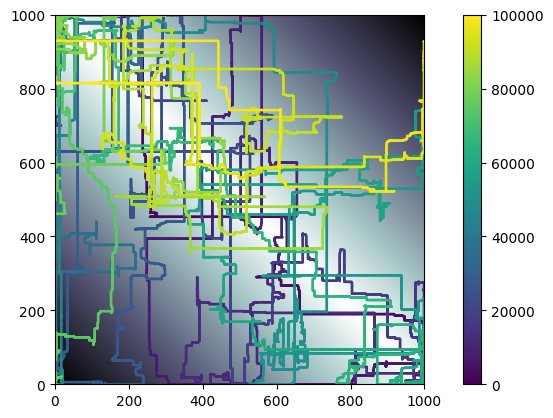

In [ ]:
ac = np.array(all_coordinates)
plt.imshow(plate, cmap='bone')
plt.scatter(ac[:,1], ac[:,0], c=range(len(ac)), s=0.5, alpha=1)
plt.colorbar();
plt.axis('square')
plt.axis([0, 1000, 0, 1000])

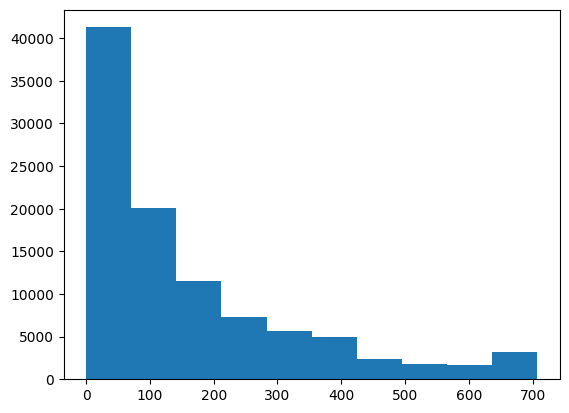

In [ ]:
# Distance from center of diagonal
dists = np.zeros(len(all_coordinates))
for i,ac in enumerate(all_coordinates):
  dists[i] = np.abs(-ac[0] + -ac[1] + 1000) / np.sqrt(2)
plt.hist(dists);

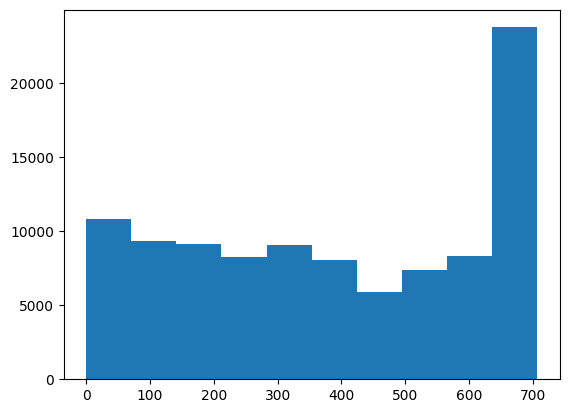

In [ ]:
# Compare to distance to y=x
dists = np.zeros(len(all_coordinates))
for i,ac in enumerate(all_coordinates):
  dists[i] = np.abs(-ac[0] + ac[1]) / np.sqrt(2)
plt.hist(dists);

# Jonah: bandits

In [ ]:
def bandit(motors, rewards=[0.1, 0.01, 1.]):
  lever_ind = jnp.argmax(motors)
  return rewards[lever_ind], lever_ind

In [ ]:
timesteps = 30_000
sizes = [1, 30, 5]
start_seed = 12655
rewards = [0., 0., 0., 0., 0.5]



initial_input = jnp.array([0.5])


hps = {

    'sizes' : sizes,

    'gamma' : 0.01, # Activity update rate
    'alpha' : 0.01, # Weight update rate

    'noise_beta'  : 0.01,  # Activity history update rate for noise scale
    'denom_constant' : 0.25, # Constant to add to denominator in energy term
    'noise_scale' : 0.01, # Activity noise scale

    'weight_noise_scale' : 0.01, # Weight noise scale

    'seed' : start_seed,

}

activities, weights, key = init_params(hps)
activity_history = deepcopy(activities)

log = PCNLog(hps)
levers = np.zeros(timesteps)
energies = np.zeros(timesteps)

activities[0] = initial_input
reward_history = jnp.array([0.])

for t in range(timesteps):

  if t%10000==0:
    print(t)

  reward, levers[t] = bandit(activities[-1], rewards=rewards)

  activities = update_acts_energy(activities, weights, activity_history, hps)
  activities, activity_history, key = act_noise(activities, activity_history, key, hps)

  weights = update_weights_energy(activities, weights, activity_history, hps)
  weights, key = weight_noise(weights, key, hps)
  weights = weight_clip(weights, cap=1.)

  activities[0] = jnp.array([reward])

  log.record(activities, weights)
  energies[t] = energy(activities, weights, activity_history, hps)

0
10000
20000


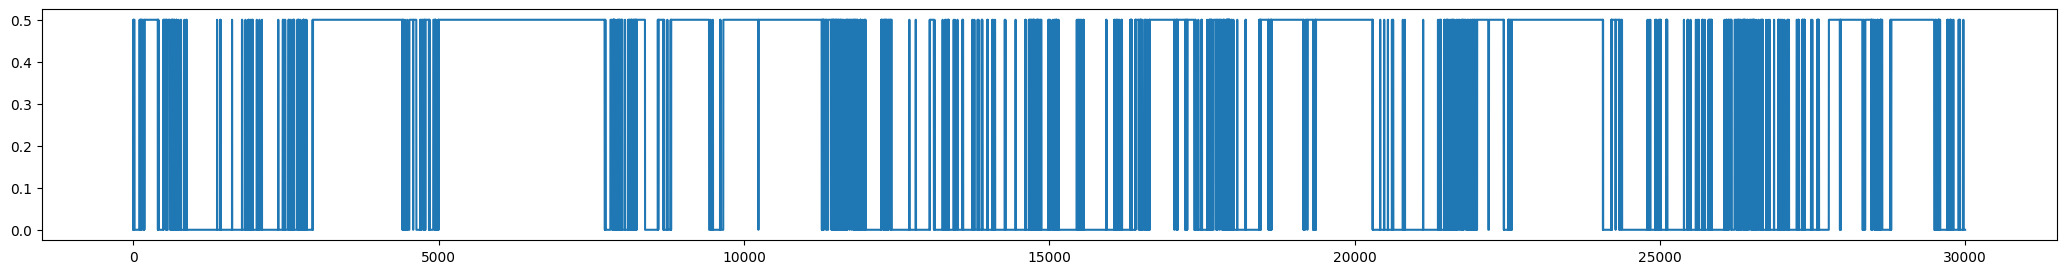

In [ ]:
plt.figure(figsize=(26,3))
plt.plot(log.acts[0])

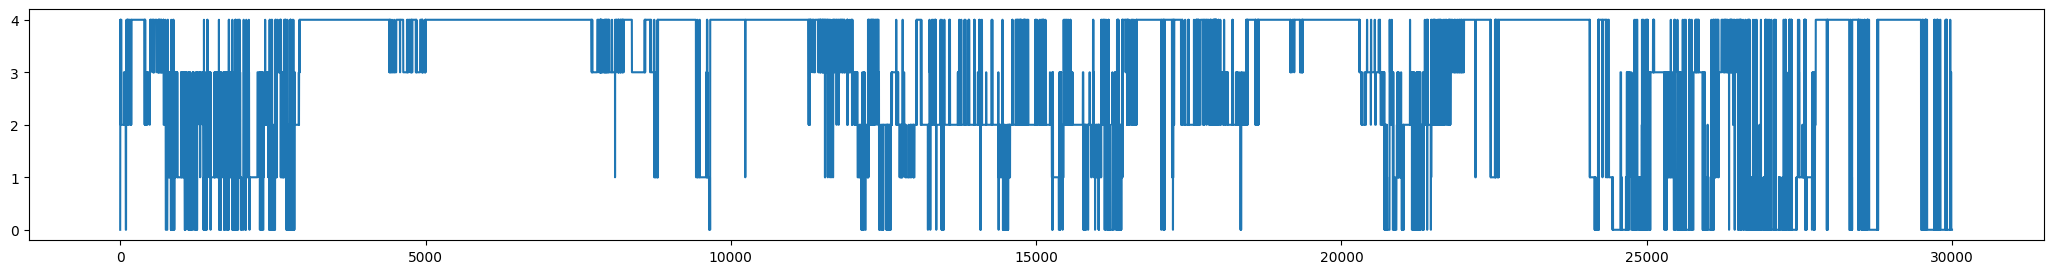

In [ ]:
plt.figure(figsize=(26,3))
plt.plot(levers)

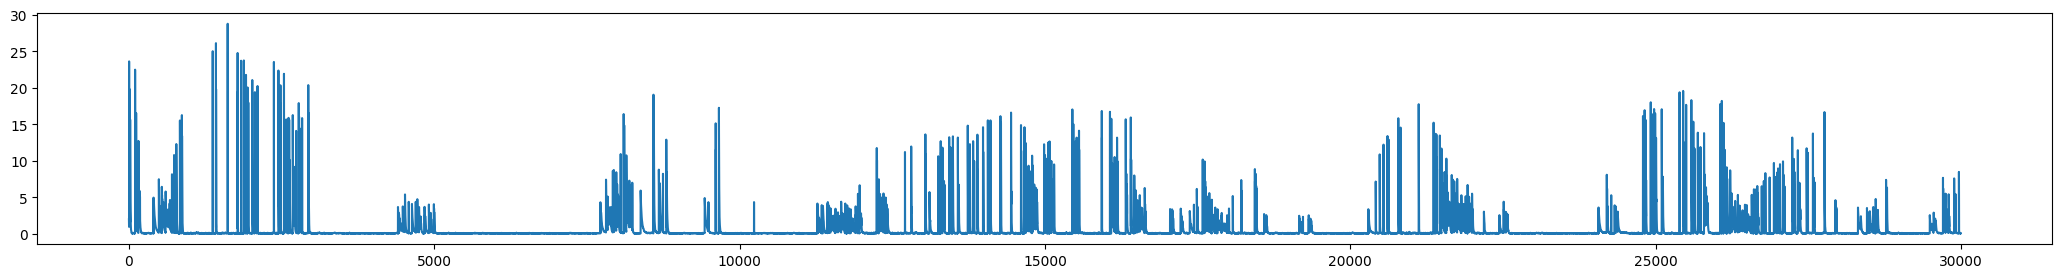

In [ ]:
plt.figure(figsize=(26,3))
plt.plot(energies)

## Image learning
Note here: This network doesn't have biases, so Relus have to cut at 0 which limits the expressivity of the network. Easy way to fix this would be to add a neuron to each layer that's always on (equivalent to adding a bias term).

This is just in case you start playing with it and find it can't learn certain functions; I don't think you'll need to add biases for the context stuff though.

In [ ]:
images = jnp.array([[0., .25, .5], [.25, 0., .5], [0.25, 0.25, .5]])
targets = jnp.array([0.4, 0.8, 0.2])

In [ ]:
def ff_test(input, activities, weights):
  # Returns activities of network after FULL feedforward pass (not just one step)
  # The activities input is just to get shape; not actually used
  new_acts = deepcopy(activities)
  new_acts[0] = input
  for l in range(len(activities)-1):
    new_acts[l+1] = jnp.matmul(weights[l], relu(new_acts[l]))
  return new_acts

def eval_images(images, activities, weights):
  g = []
  for i in range(len(images)):
    guesses = ff_test(images[i], activities, weights)
    g.append(guesses[-1])
  acc = jnp.mean(jnp.square(jnp.array(g) - targets))
  return acc

### No noise

In [ ]:
timesteps = 100_000
sizes = [3, 20, 1]
start_seed = 26


hps = {

    'sizes' : sizes,

    'gamma' : 0.01, # Activity update rate
    'alpha' : 0.01, # Weight update rate

    'noise_beta'  : 0.01,  # Activity history update rate for noise scale
    'denom_constant' : 0.25, # Constant to add to denominator in energy term
    'noise_scale' : 0.00, # Activity noise scale

    'weight_noise_scale' : 0.00, # Weight noise scale

    'seed' : start_seed

}

log = PCNLog(hps)

activities, weights, key = init_params(hps)
activity_history = deepcopy(activities)

energies = []
accs = []
current_im = 0
presentation_time = 200


for t in range(timesteps):

  if t % 1000 == 0:
    print(t)

  if t % presentation_time == 0:
    current_im = (current_im + 1) % len(images)

  log.record(activities, weights)

  # Present image and target
  activities[0] = images[current_im]
  activities[-1] = targets[current_im]

  # Train
  activities = update_acts_energy(activities, weights, activity_history, hps)
  #log.record(activities, weights)
  activities, activity_history, key = act_noise(activities, activity_history, key, hps)

  weights = update_weights_energy(activities, weights, activity_history, hps)
  weights, key = weight_noise(weights, key, hps)
  weights = weight_clip(weights, cap=1.)

  energies.append(energy(activities, weights, activity_history, hps))
  accs.append(eval_images(images, activities, weights))


Text(0.5, 1.0, 'Energy')

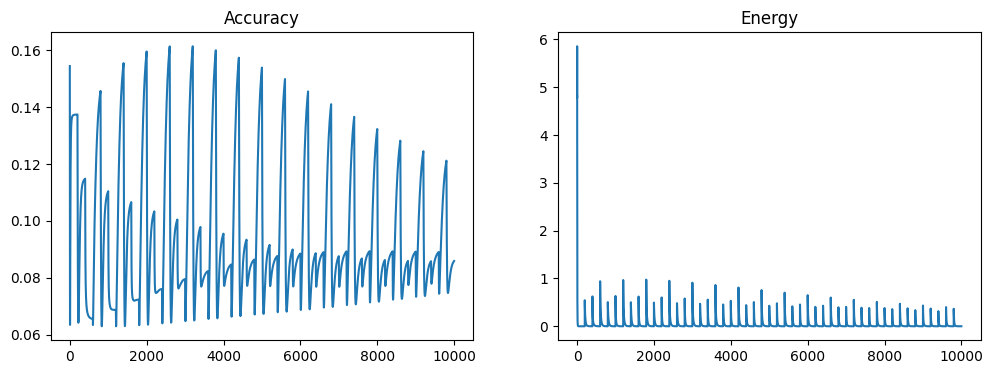

In [ ]:
# Note accuracy minimization != energy minimization
fig,ax = plt.subplots(1,2)
fig.set_size_inches((12,4))
ax[0].plot(accs)
ax[0].set_title('Accuracy')
ax[1].plot(energies)
ax[1].set_title('Energy')

If the presentation time is too short, learning is hard

In [ ]:
current_im

2

In [ ]:
# Since the current image is the last one, previous accuracies are not as good
g = []
for i in range(len(images)):
  guesses = ff_test(images[i], activities, weights)
  g.append(guesses[-1])
for g_i, l_i in zip(g, targets):
  print(f'Guess {g_i}, real {l_i:.2f}')

Guess [0.41958043], real 0.40
Guess [0.47602254], real 0.80
Guess [0.2046807], real 0.20


In [ ]:
timesteps = 200
sizes = [3, 20, 1]
start_seed = 26

current_im = 0

for t in range(timesteps):

  log.record(activities, weights)

  # Present image and target
  activities[0] = images[current_im]
  activities[-1] = targets[current_im]

  # Train
  activities = update_acts_energy(activities, weights, activity_history, hps)
  #log.record(activities, weights)
  activities, activity_history, key = act_noise(activities, activity_history, key, hps)

  weights = update_weights_energy(activities, weights, activity_history, hps)
  weights, key = weight_noise(weights, key, hps)
  weights = weight_clip(weights, cap=1.)


In [ ]:
# Current im==0
g = []
for i in range(len(images)):
  guesses = ff_test(images[i], activities, weights)
  g.append(guesses[-1])
for g_i, l_i in zip(g, targets):
  print(f'Guess {g_i}, real {l_i:.2f}')

Guess [0.40350553], real 0.40
Guess [0.4670392], real 0.80
Guess [0.19079994], real 0.20


In [ ]:
timesteps = 200
sizes = [3, 20, 1]
start_seed = 26

current_im = 1

for t in range(timesteps):

  log.record(activities, weights)

  # Present image and target
  activities[0] = images[current_im]
  activities[-1] = targets[current_im]

  # Train
  activities = update_acts_energy(activities, weights, activity_history, hps)
  #log.record(activities, weights)
  activities, activity_history, key = act_noise(activities, activity_history, key, hps)

  weights = update_weights_energy(activities, weights, activity_history, hps)
  weights, key = weight_noise(weights, key, hps)
  weights = weight_clip(weights, cap=1.)


In [ ]:
# Current im==1
g = []
for i in range(len(images)):
  guesses = ff_test(images[i], activities, weights)
  g.append(guesses[-1])
for g_i, l_i in zip(g, targets):
  print(f'Guess {g_i}, real {l_i:.2f}')

Guess [0.723853], real 0.40
Guess [0.7914425], real 0.80
Guess [0.53302634], real 0.20


So there's a decent amount of forgetting between cycles.

In [29]:
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    return np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

# Define the grid dimensions
grid_size = 1000
x = np.linspace(0, 999, grid_size)
y = np.linspace(0, 999, grid_size)
x, y = np.meshgrid(x, y)

# Define the parameters for the Gaussian distribution
x_peak, y_peak = 500, 500  # peak position
sigma_x, sigma_y = 150, 150  # standard deviations

# Generate the 2D Gaussian distribution
z = gaussian_2d(x, y, x_peak, y_peak, sigma_x, sigma_y)

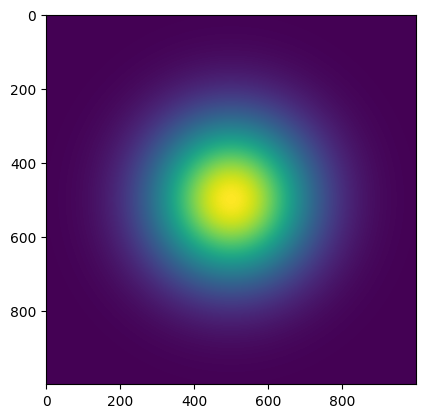

In [30]:
plt.imshow(z)

In [31]:
angle = np.linspace(0, 2*np.pi, num=100)
r = 250
xs, ys = r*np.cos(angle) + 500, r*np.sin(angle) + 500

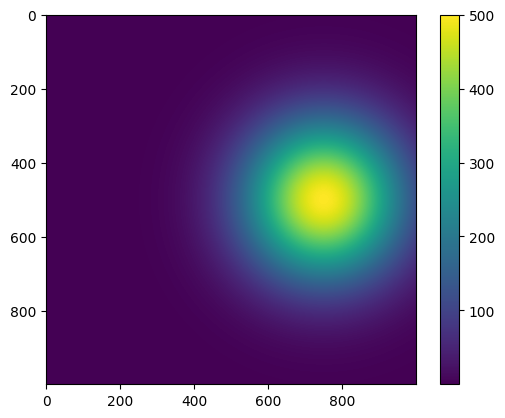

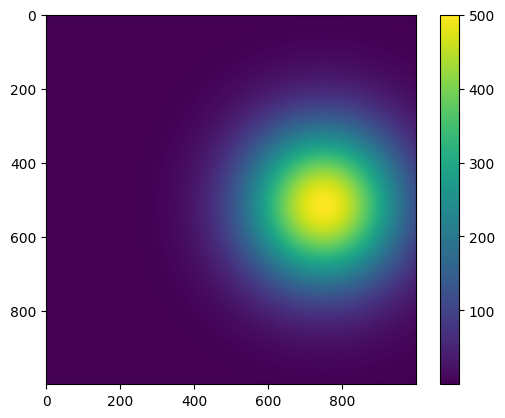

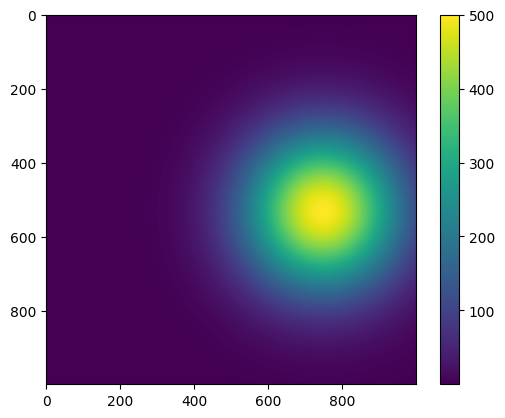

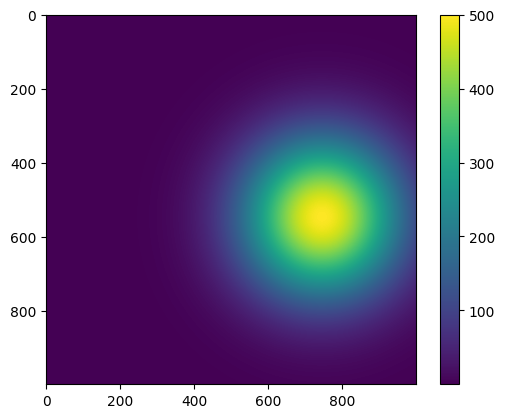

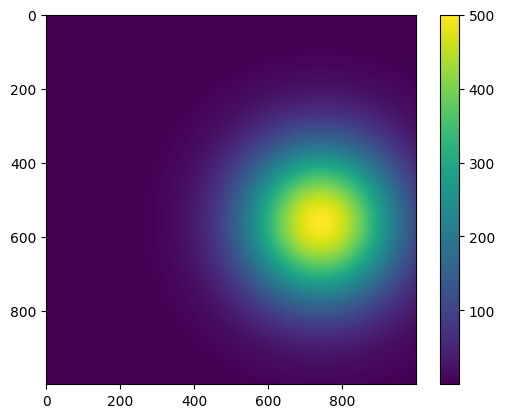

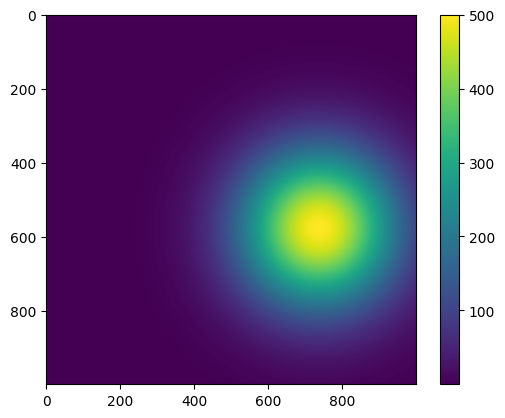

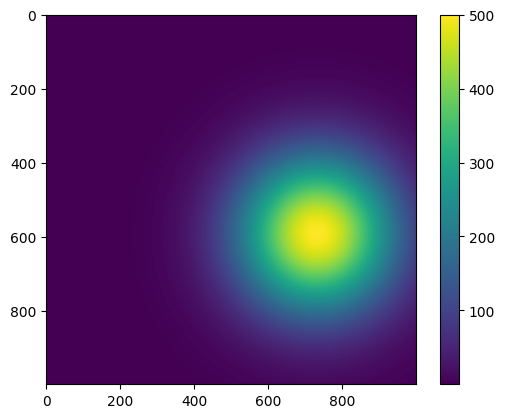

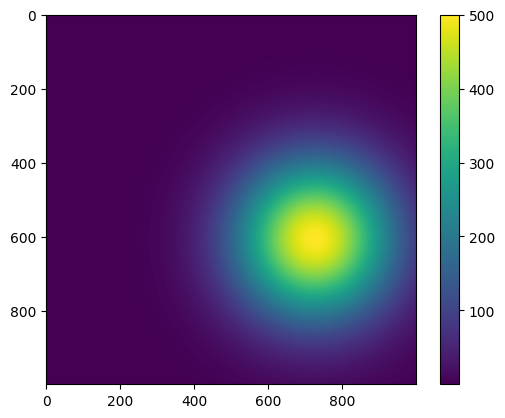

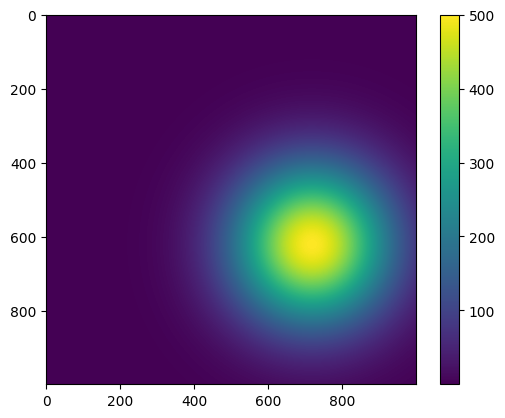

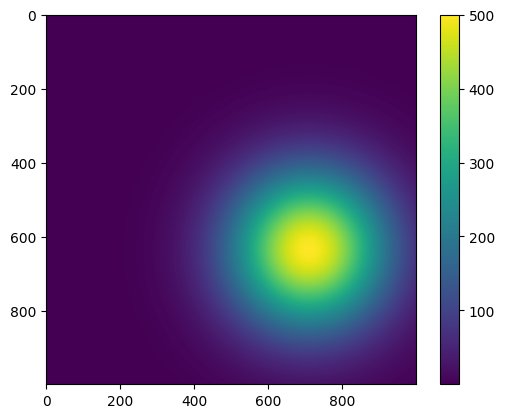

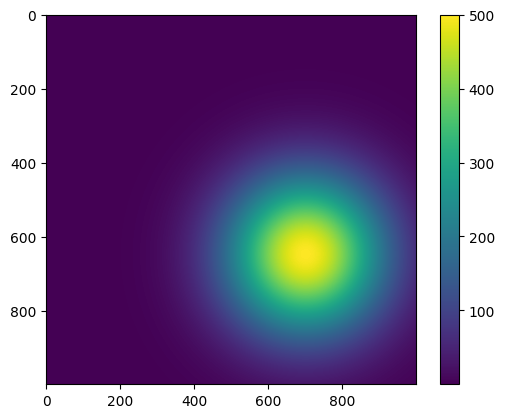

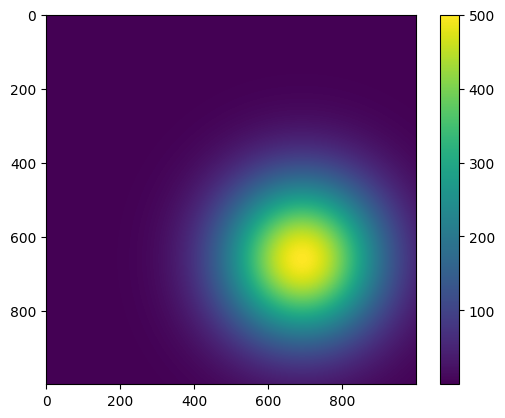

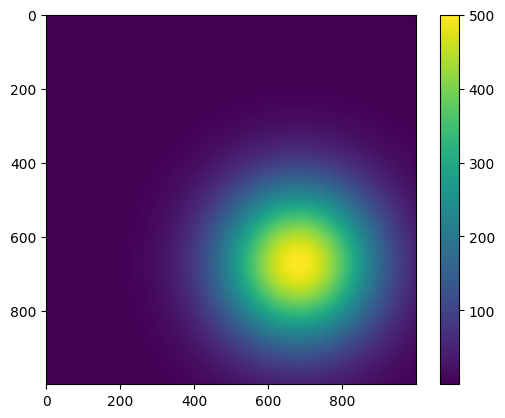

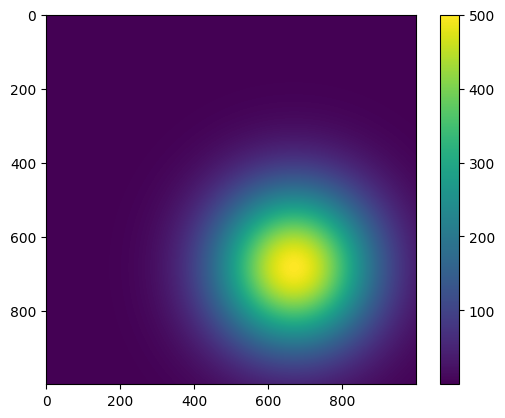

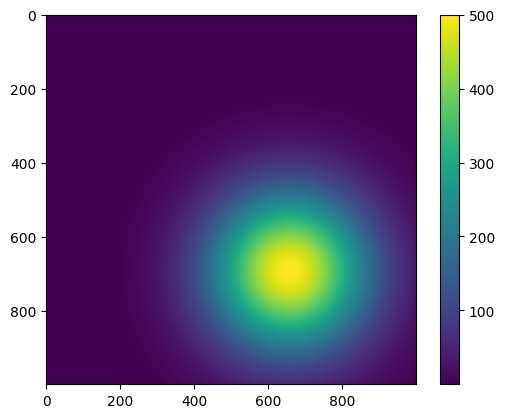

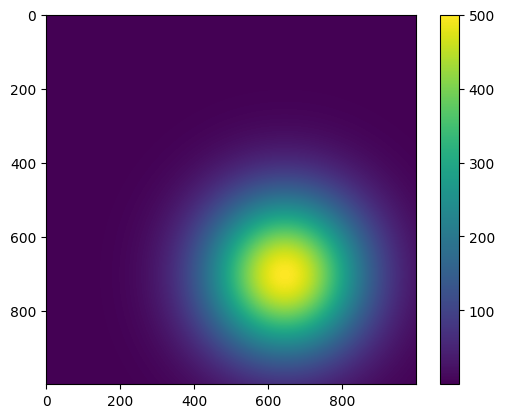

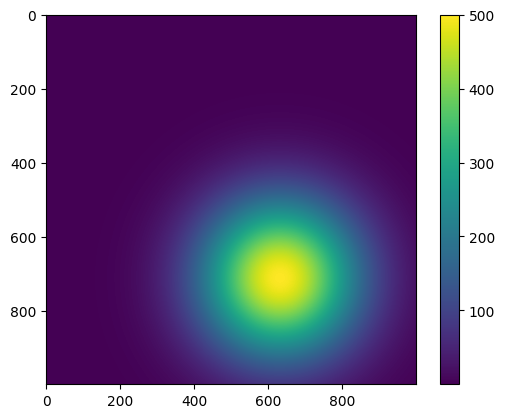

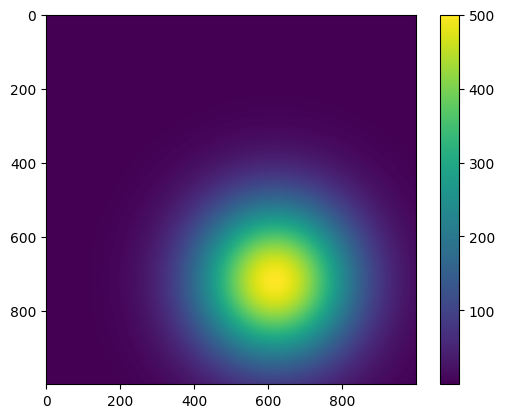

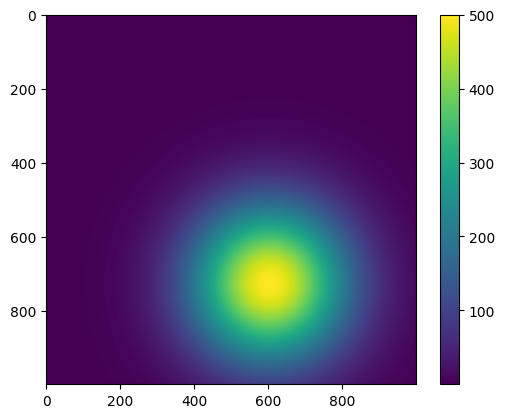

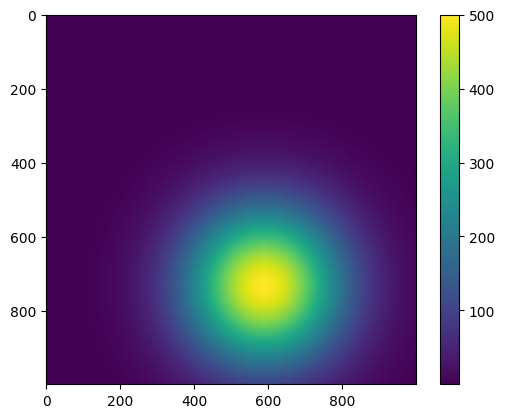

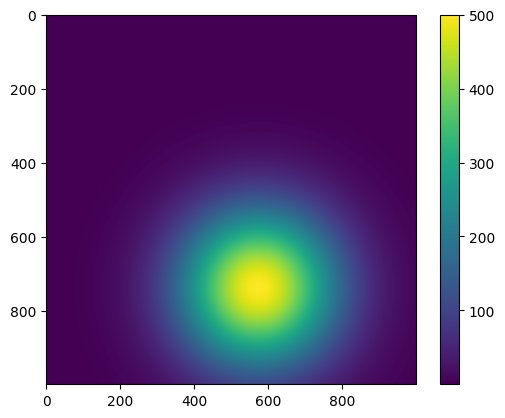

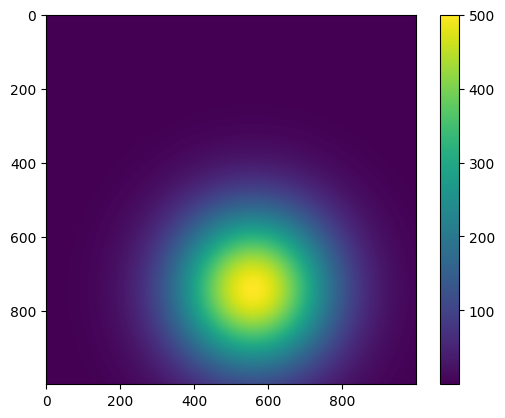

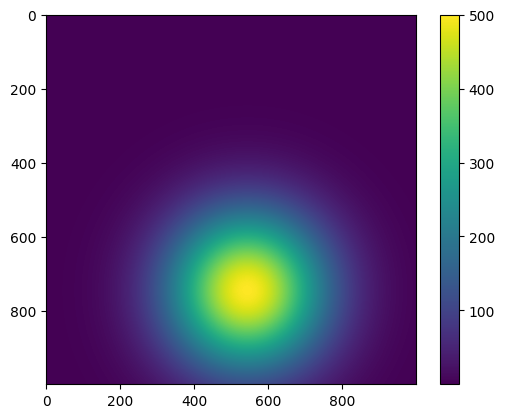

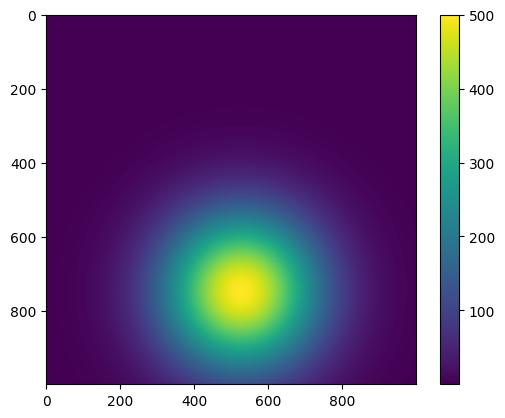

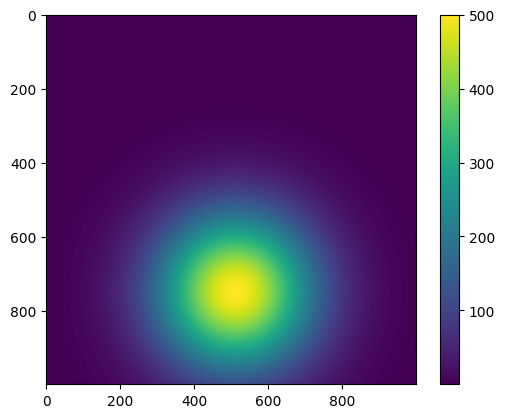

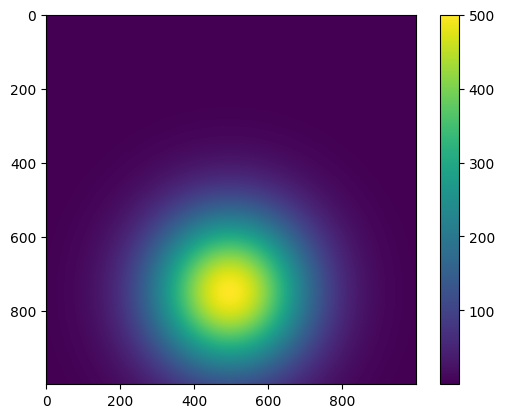

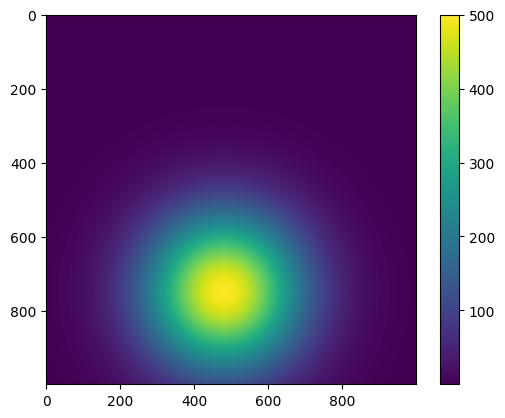

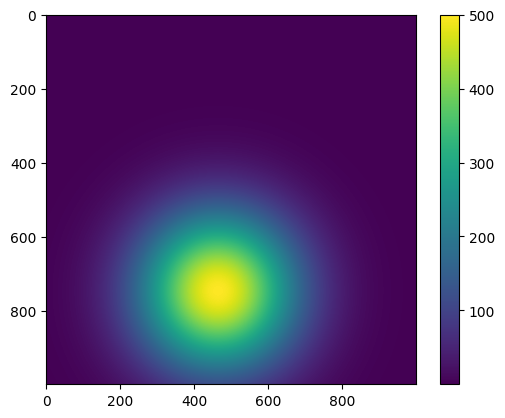

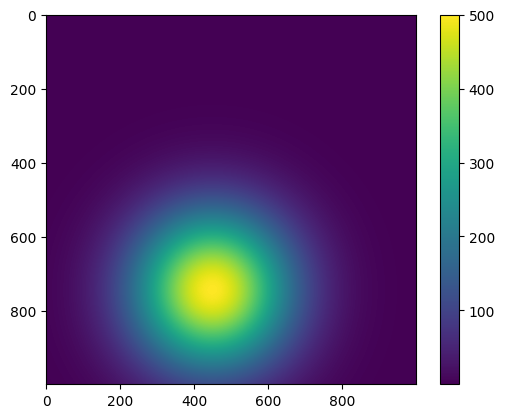

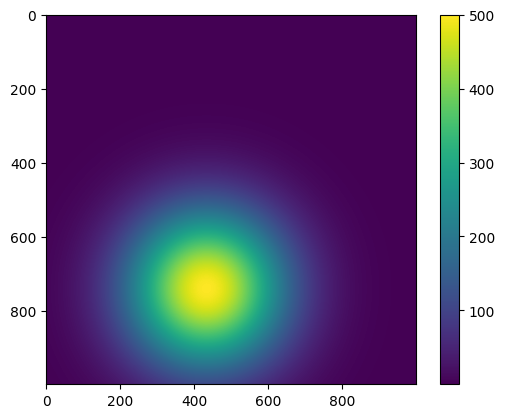

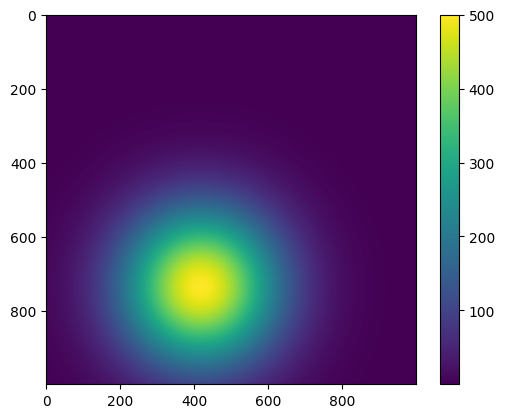

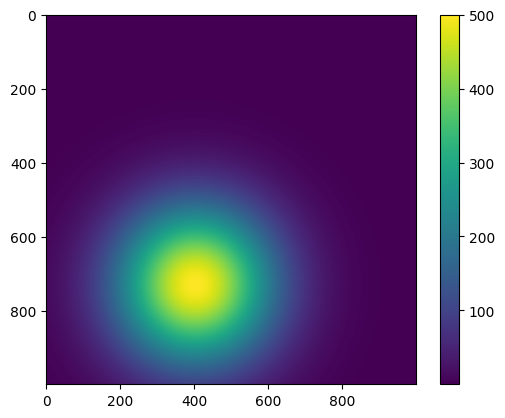

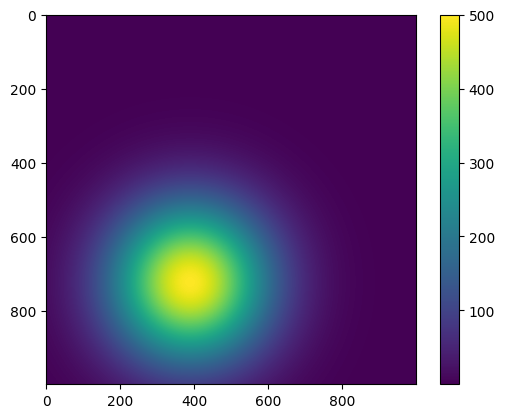

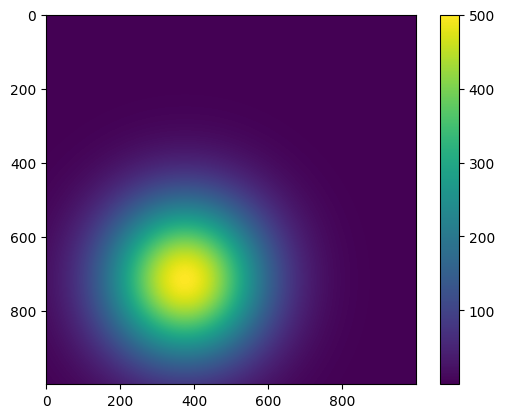

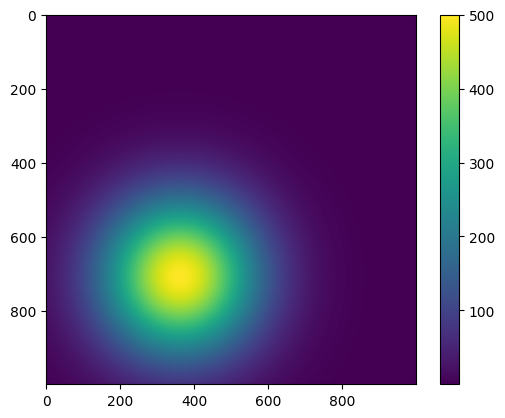

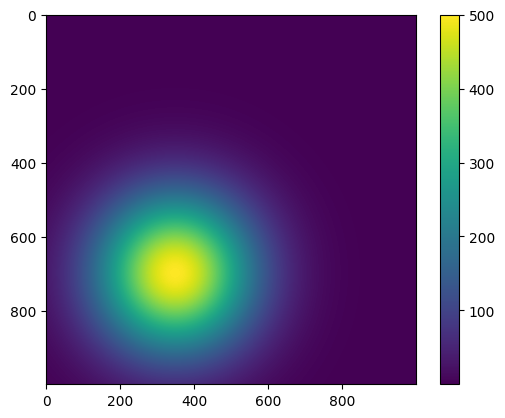

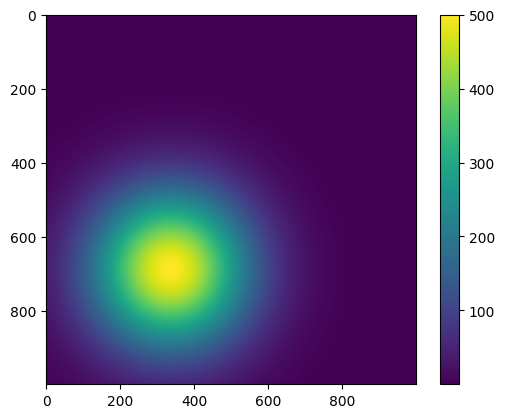

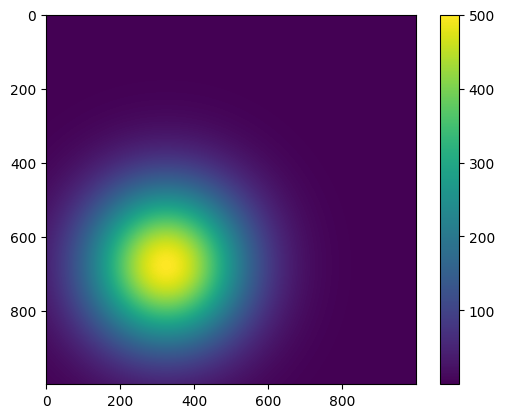

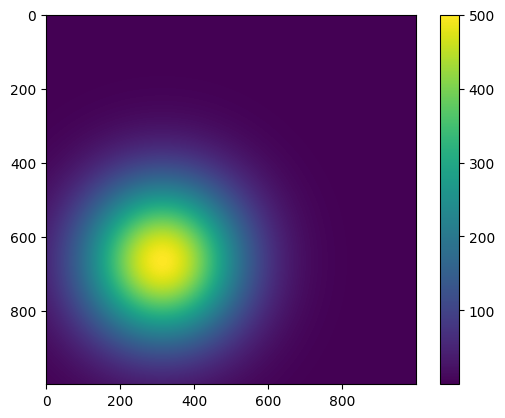

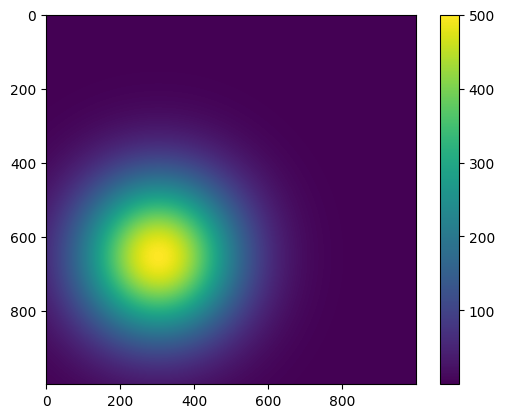

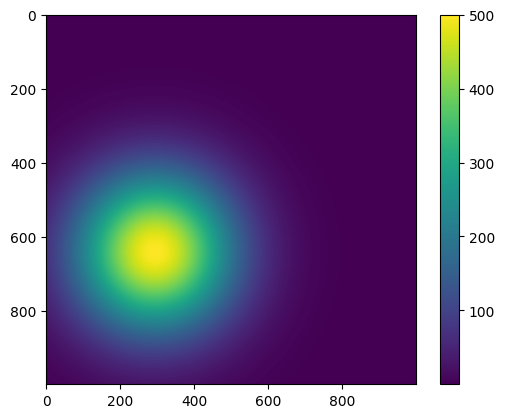

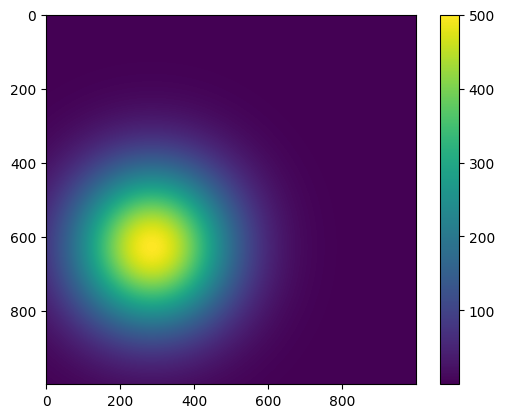

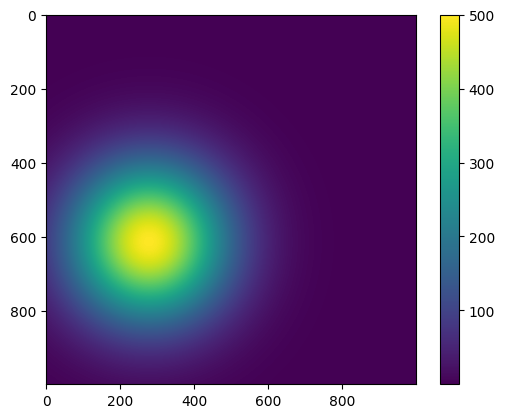

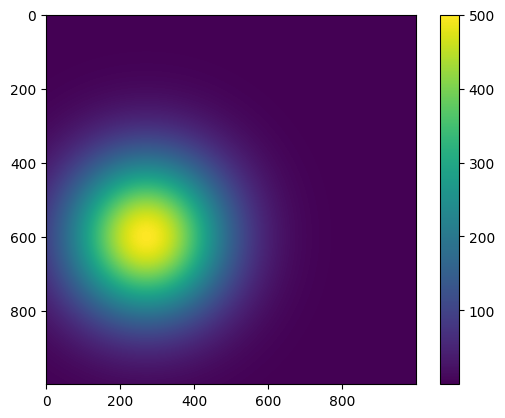

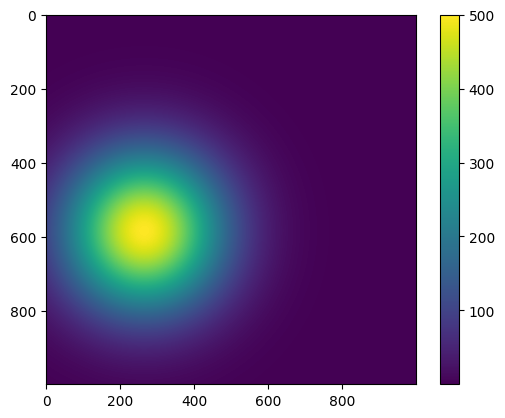

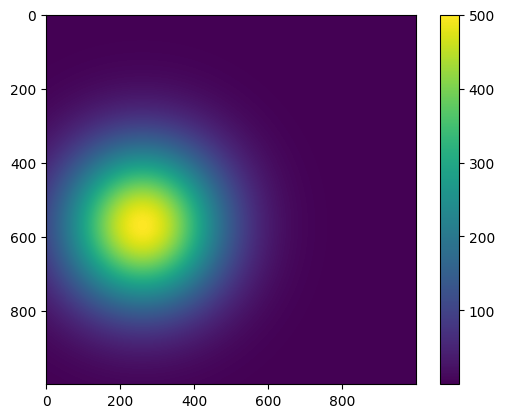

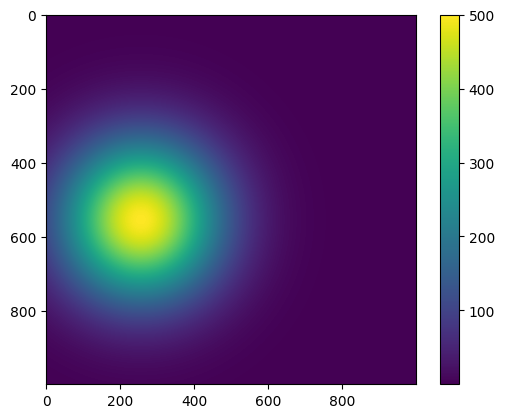

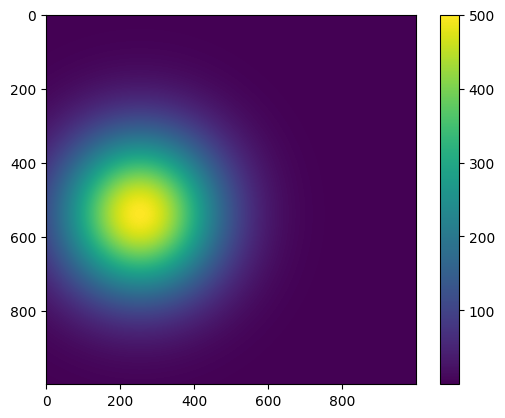

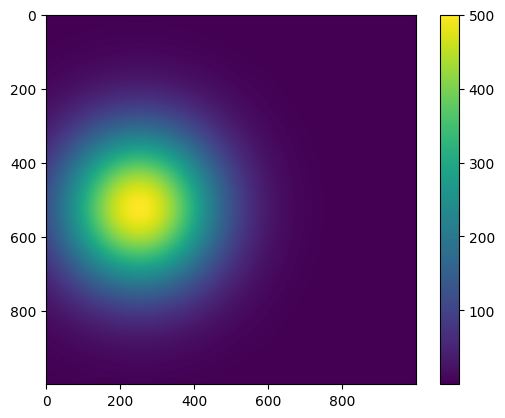

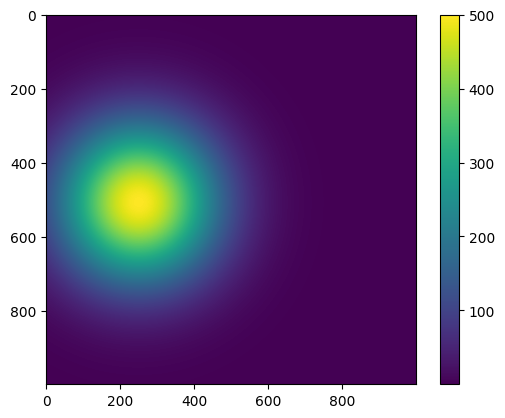

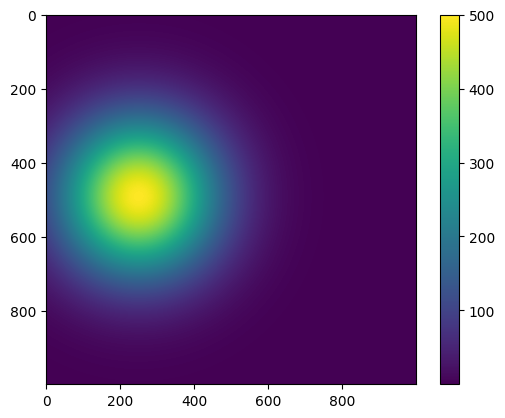

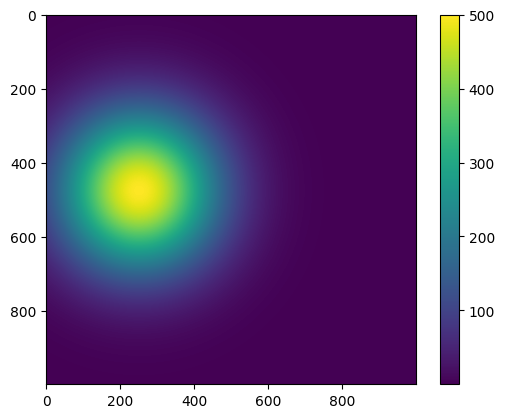

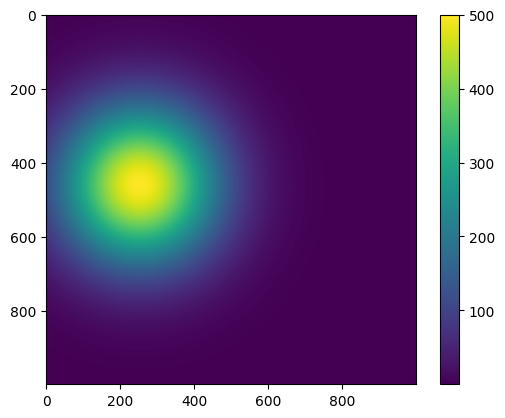

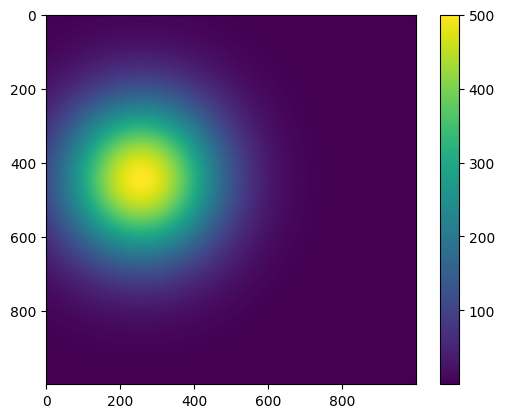

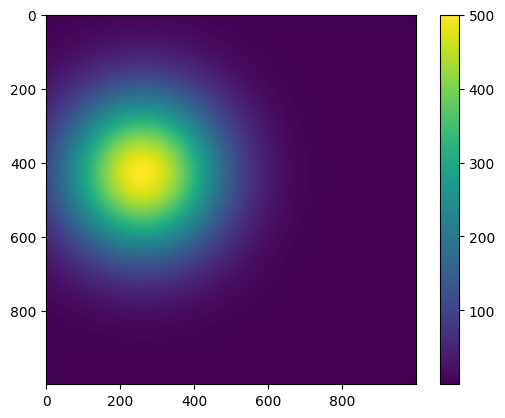

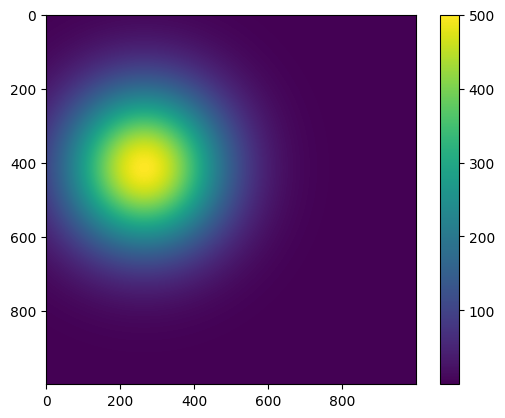

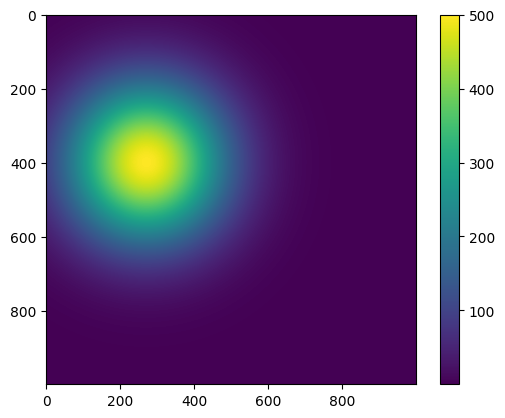

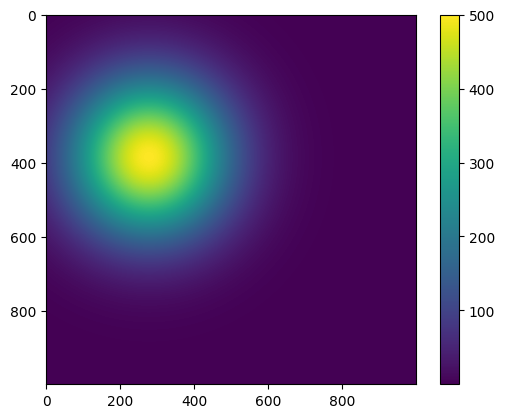

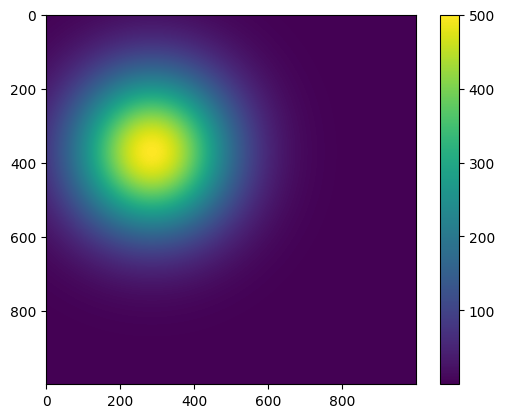

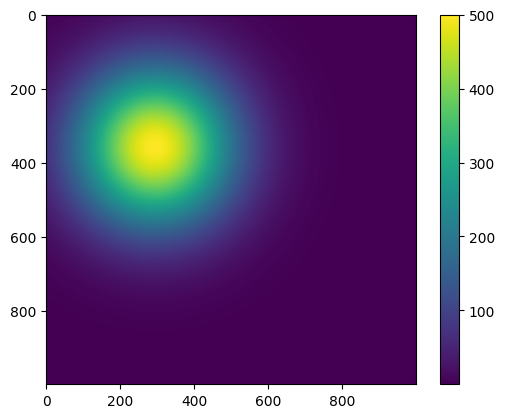

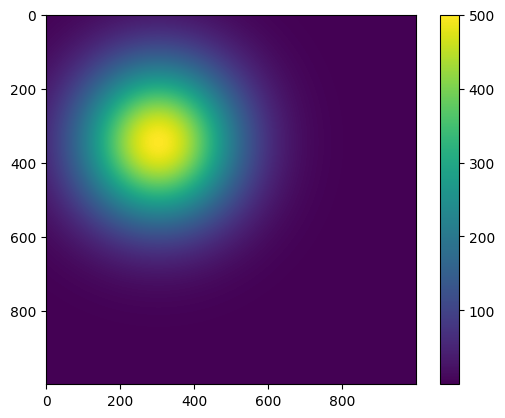

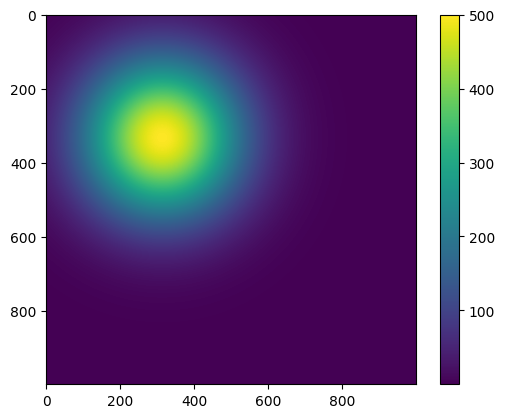

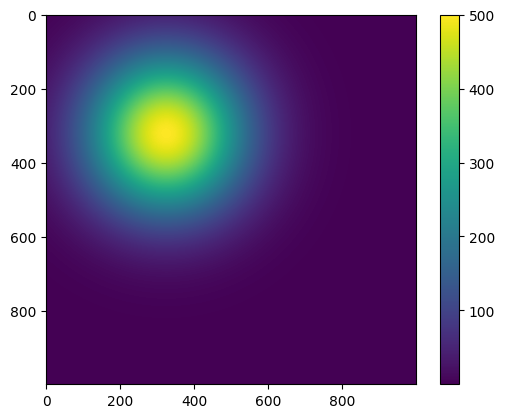

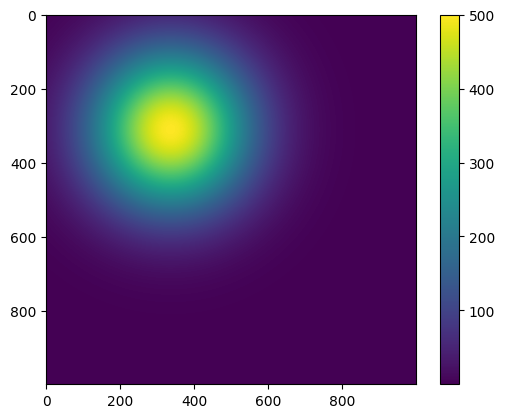

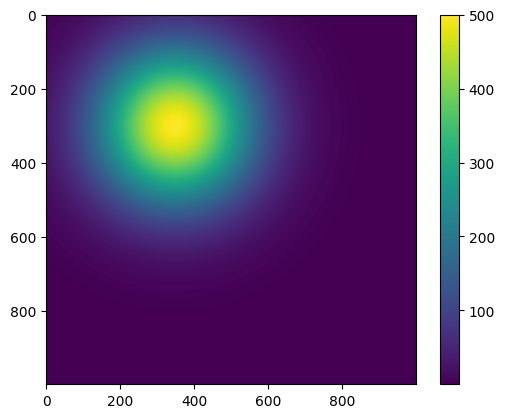

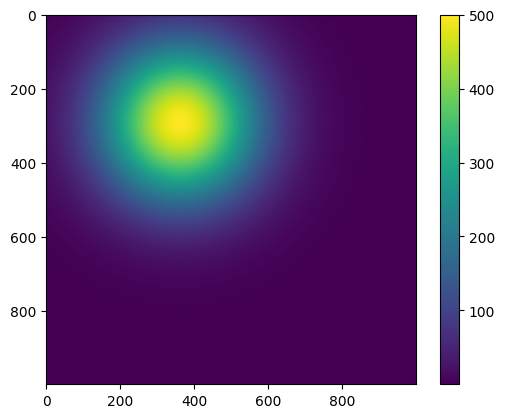

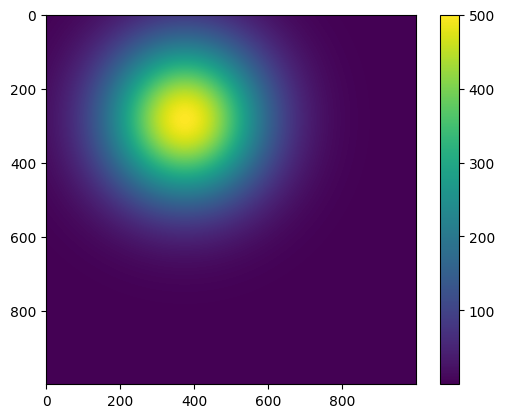

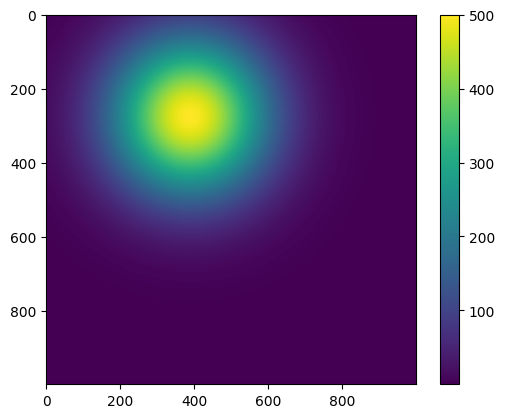

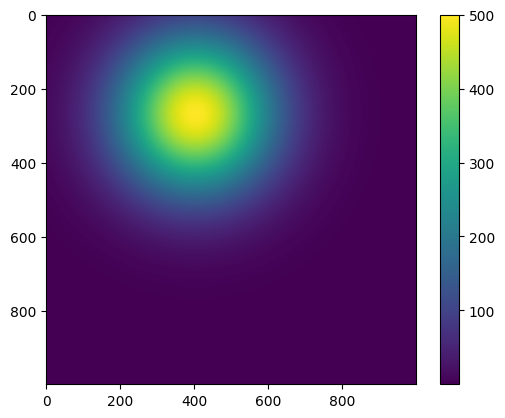

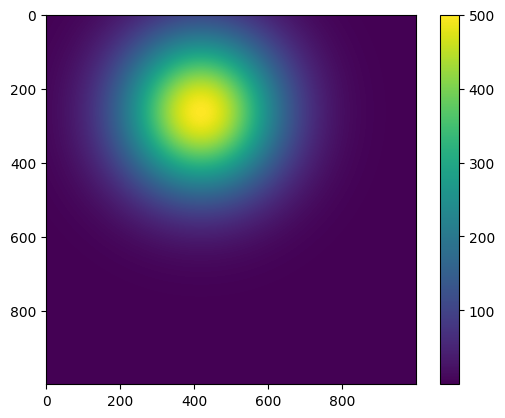

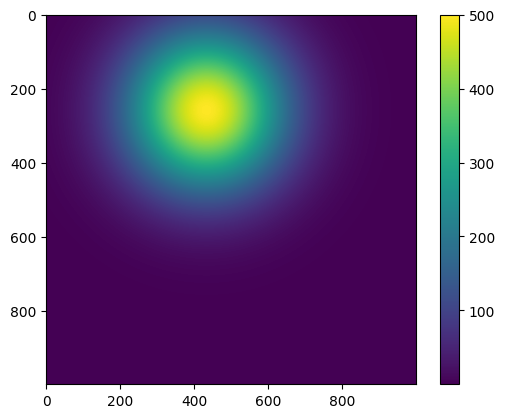

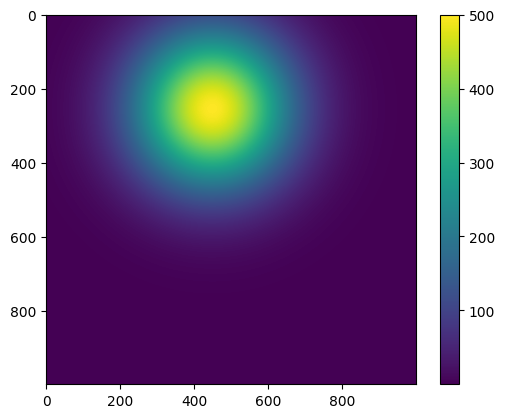

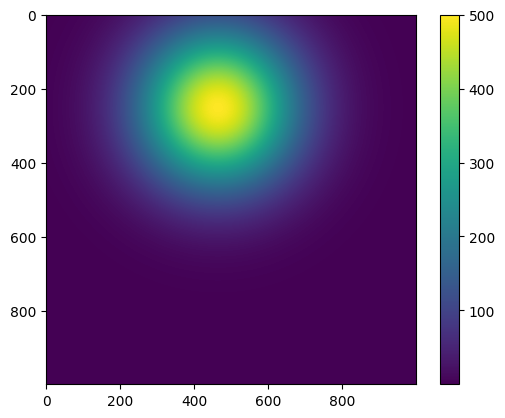

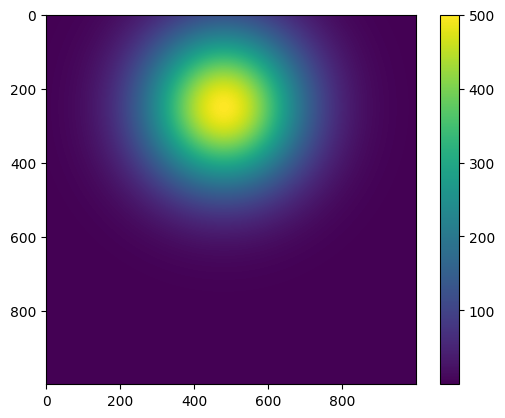

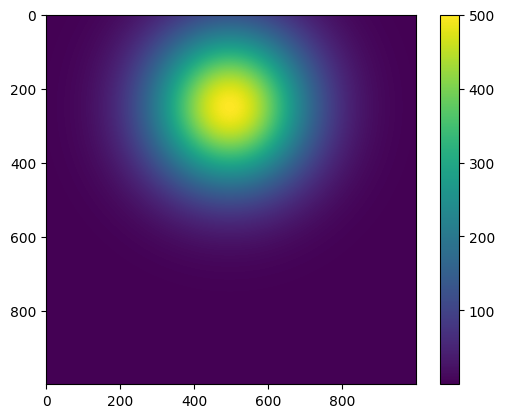

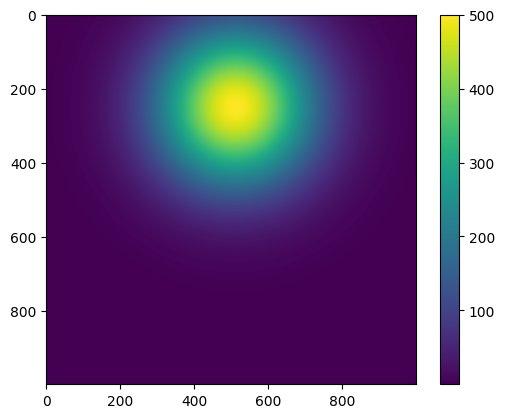

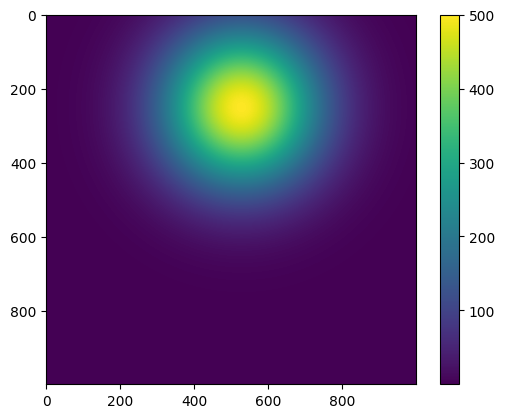

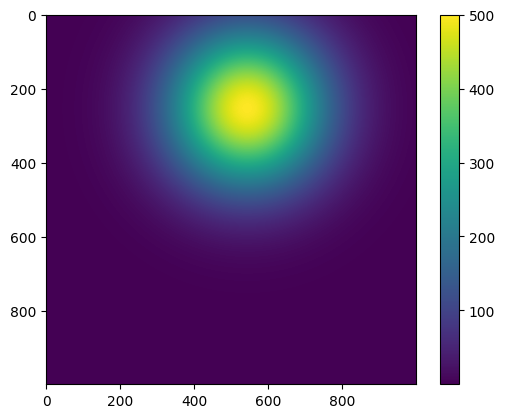

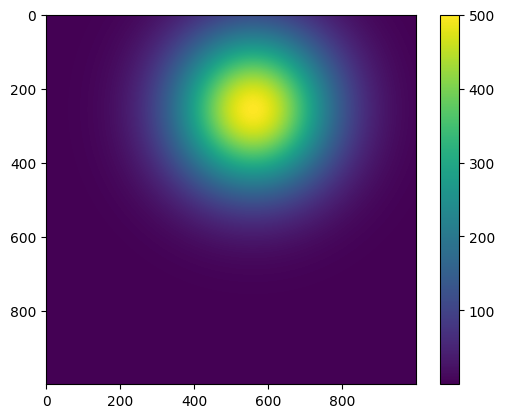

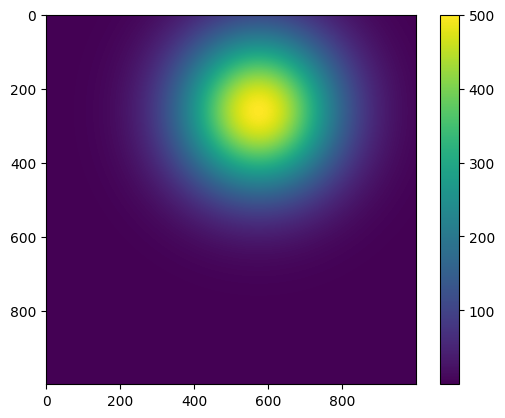

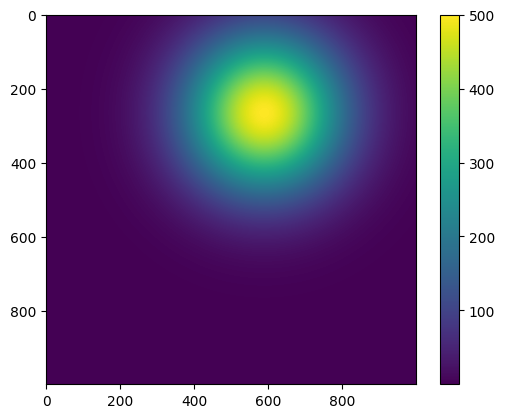

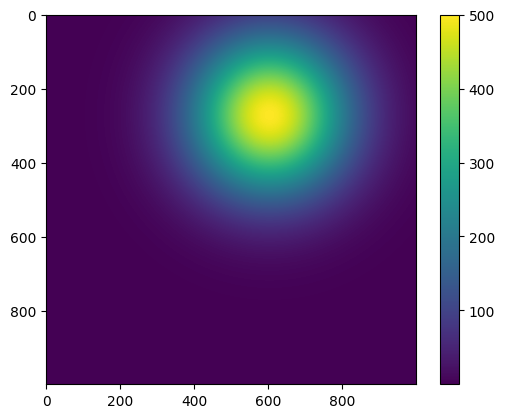

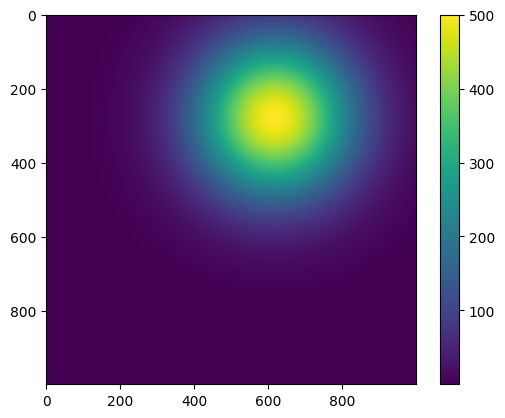

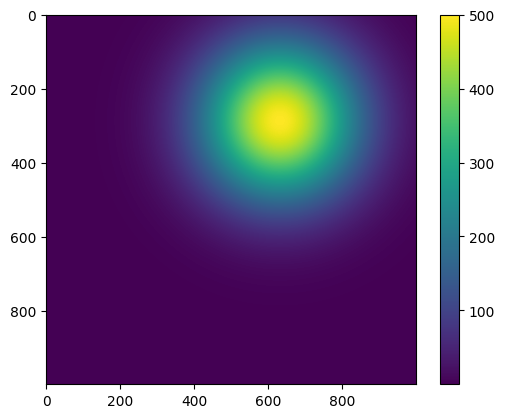

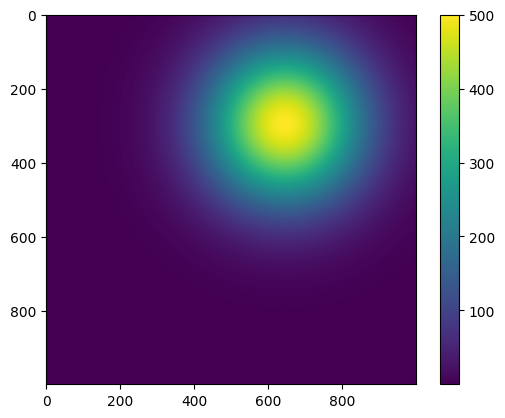

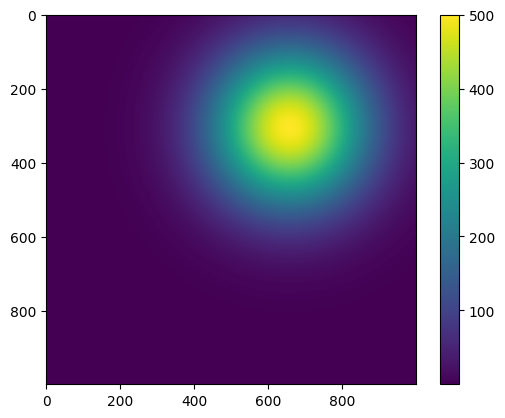

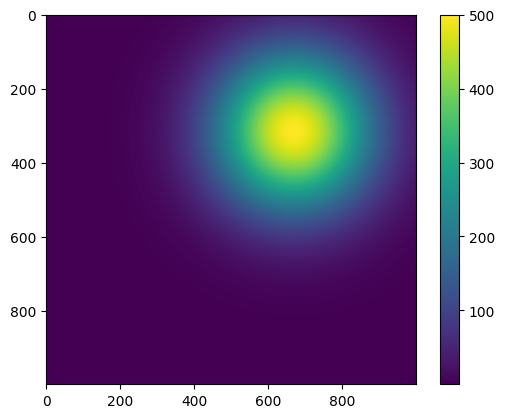

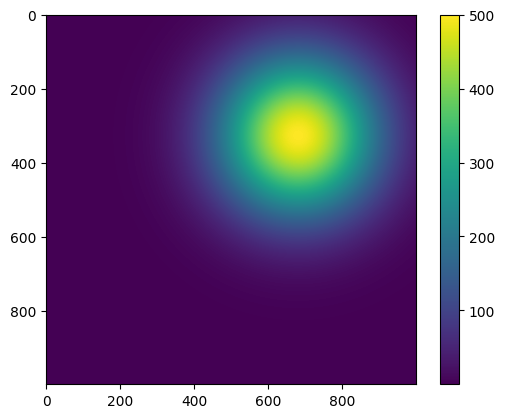

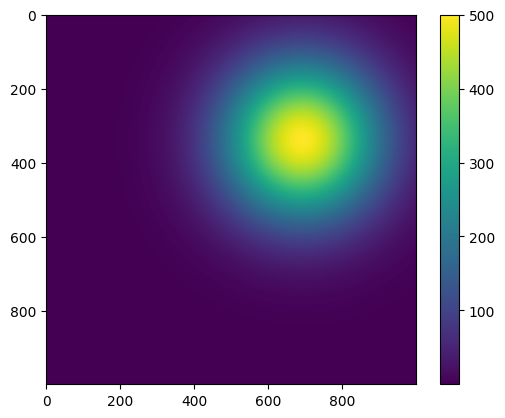

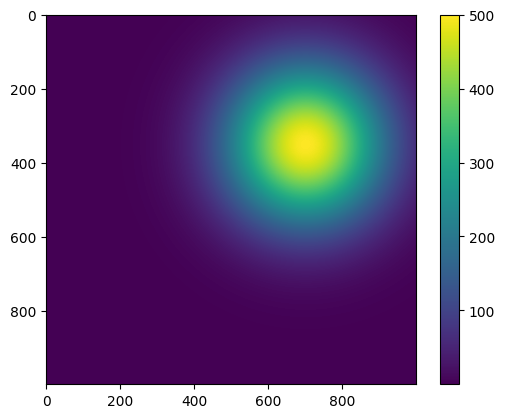

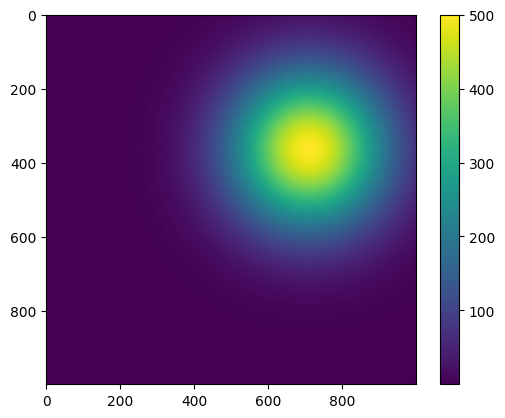

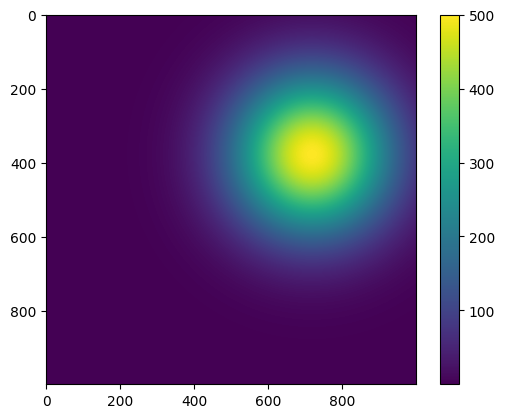

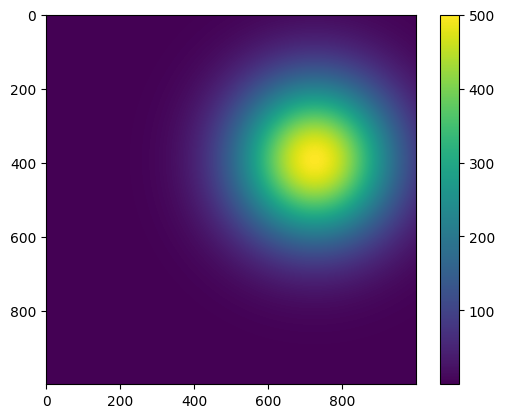

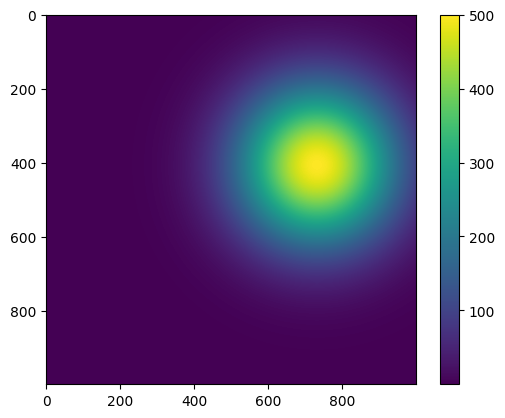

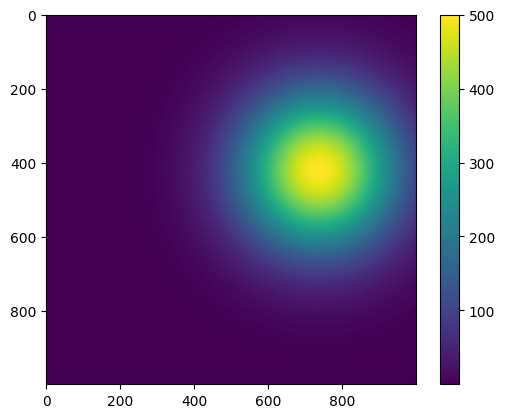

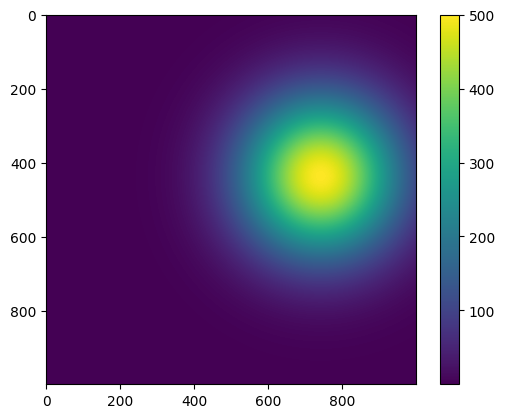

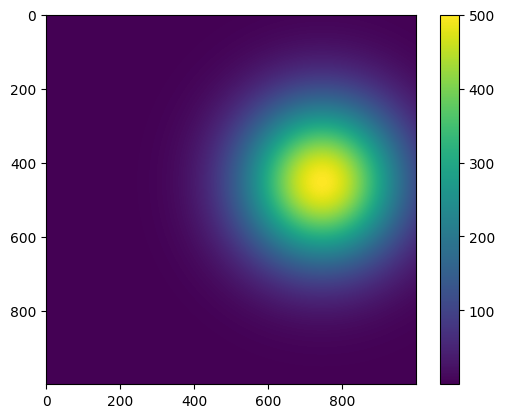

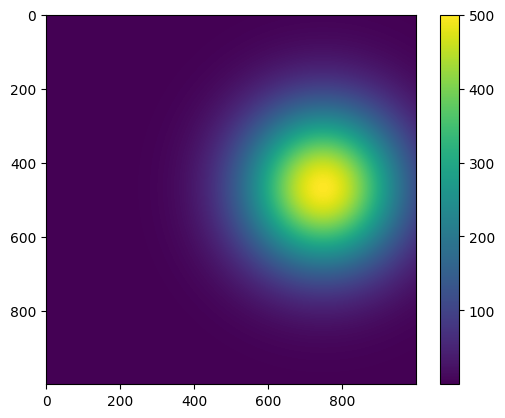

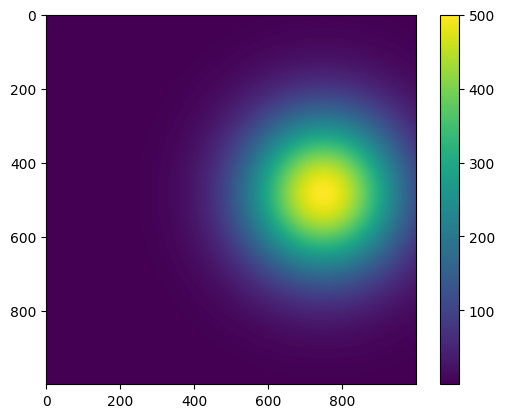

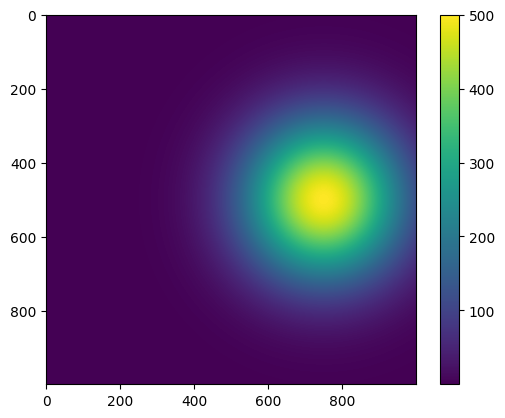

In [33]:
for x_peak, y_peak in zip(xs, ys):
  z = gaussian_2d(x, y, x_peak, y_peak, sigma_x, sigma_y)
  z = (z * 500) / np.max(z)
  plt.figure()
  plt.imshow(z)
  plt.colorbar()
  plt.show()